# Técnicas Clássicas de Reconhecimento de Padrões (2020/01)
## Exercício 05 - Mistura de Gaussianas e KDE

**Aluno: Ramon Gomes Durães de Oliveira (2019720188)**

Neste exercício será implementado um classificador Bayesiano baseado em mistura de gaussianas com clustering e KDE. Suas características e propriedades serão explorados em dados sintéticos não-linearmente separáveis e, em seguida, nos dados de leucemia (Golub et al 1999).

## Gerando os Dados Sintéticos: Classificação de Espirais

Abaixo, serão geradas duas classes sintéticas utilizando gaussianas multivariadas. Uma delas apresentará correlação entre os eixos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import random
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

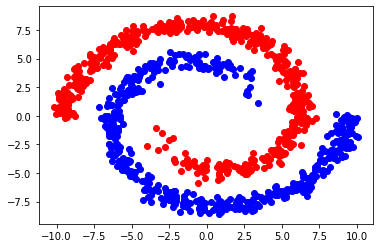

In [2]:
# Função para geração da base de dados sintética
def twospirals(n_points, n_turns, ts=np.pi, tinc=1, noise=.3):
    """
     Returns the two spirals dataset.
     modificado de: 
         https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
     Primeiro gera uma espiral e obtem a segunda espelhando a primeira
    """
    # equação da espiral (coord polares): r = tinc*theta
    # n_points: número de pontos de cada espiral
    # n_turns: número de voltas das espirais
    # ts: ângulo inicial da espiral em radianos
    # tinc: taxa de crescimento do raio em função do ângulo
    # noise: desvio-padrão do ruído
    
    # Sorteando aleatoriamente pontos da espiral
    n = np.sqrt(np.random.rand(n_points,1))  #intervalo [0,1] equivale a [0,theta_max]
                                             #tomar a raiz quadrada ajuda a 
                                             #distribuir melhor os pontos
    ns = (ts)/(2*np.pi*n_turns) #ponto do intervalo equivalente a ts radianos
    n = ns + n_turns*n # intervalo [ns,ns+n_turns] equivalente a [ts, theta_max]
    n = n*(2*np.pi) #intervalo [ts, theta_max]
    
    # Espiral 1
    d1x = np.cos(n)*tinc*n + np.random.randn(n_points,1) * noise
    d1y = np.sin(n)*tinc*n + np.random.randn(n_points,1) * noise
    
    # Espiral 2
    d2x = -np.cos(n)*tinc*n + np.random.randn(n_points,1) * noise
    d2y = -np.sin(n)*tinc*n + np.random.randn(n_points,1) * noise
    
    spirals_points = np.vstack((np.hstack((d1x,d1y)),np.hstack((d2x,d2y))))
    points_labels = np.hstack((np.ones(n_points),np.zeros(n_points)))
    return (spirals_points, points_labels)

X, y = twospirals(500,1,ts=np.pi,tinc=1,noise=0.4)
X1 = X[y==1,:]
X2 = X[y==0,:]
plt.plot(X1[:,0],X1[:,1],'or')
plt.plot(X2[:,0],X2[:,1],'ob')
plt.show()

## Desenvolvimento dos modelos

### Classificação por Mistura de Gaussianas

#### Clusterização por KMeans

O primeiro passo para a implementação da mistura de Gaussianas é clusterização dos dados de entrada utilizando o KMeans. Abaixo, será implementada a clusterização para os dados sintéticos.

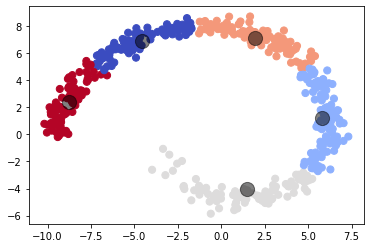

In [41]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X1)
y_kmeans = kmeans.predict(X1)
centers = kmeans.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(X1[:,0], X1[:,1],  c=y_kmeans, s=50, cmap='coolwarm')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, label='dawa');

A separação por clusters foi feita com sucesso. Este código agora é a base para a classe GM (Gaussian Mixture) mostrada abaixo. Seus métodos têm a seguinte função:
- \__init__: inicializa os parâmetros do modelo como a dimensão dos dados de entrada e o número de clusters. Além disso, a clusterização por KMeans é rodada nesta função, retornando também as proporções de pontos por cluster (pi), as médias e matrizes de covariância de cada cluster;
- multivariateGaussian: é o valor da gaussiana multivariada de média mu e covariância sigma avaliada em x;
- e_step : o passo E (Expectation) do algoritmo de Expectation Maximization. Este passo calcula, para cada ponto em X e cada cluster, a probabilidade relativa de que cada ponto pertença a cada cluster;
- m_step : o passo M (Maximization) do algoritmo de Expectation Maximization. Este passo otimiza os parâmetros de média e matriz de covariância para cada cluster de acordo com os valores de probabilidade relativa calculados pelo passo E. 
- loglikelihood : calcula a logVerossimilhança do modelo. Este valor é utilizado apenas para garantir que o algoritmo está funcionando pois este é um valor que deve aumentar a cada iteração;
- plot : plota os pontos e as médias dos clusters resultantes;
- fit : ajsuta o modelo repetindo os passos E e M iterativamente (até o limite de iterações especificado);
- predict : estima a probabilidade para um novo ponto. Esta função é utilizada para classificar novos pontos.


In [296]:
from IPython import display
import time

class GM:
    def __init__(self, X, n_clusters, assume_independence=False):
        self.X = X.astype(float)
        self.n, self.d = X.shape
        self.n_clusters = n_clusters
        self.assume_independence = assume_independence
        
        self.r = np.zeros((self.n, self.n_clusters))
        
        # Clusteriza as observações 
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.kmeans.fit(self.X)
        self.y_kmeans = self.kmeans.predict(self.X)
        self.centers = self.kmeans.cluster_centers_
        
        # Extrai parâmetros de cada cluster
        self.mu_list = list()
        self.sigma_list = list()
        self.pi_list = list()
        for cluster in np.arange(self.n_clusters):
            Xcluster = self.X[self.y_kmeans==cluster]
            self.pi_list.append(len(Xcluster) / len(X))
            self.mu_list.append(np.mean(Xcluster, axis=0).reshape((self.d, 1)))
            self.sigma_list.append(np.cov(Xcluster.T))
        
    def multivariateGaussian(self, x, mu, sigma):
        """ Função de probabilidade Gaussiana Multivariada."""
        d = max(x.shape)
        x = x.reshape((d, 1))
        mu = mu.reshape((d, 1))
        if self.assume_independence:
            sigma = np.diag(np.diag(sigma))
        term1 = 1/np.power(2*np.pi, (d / 2))
        term2 = np.power(np.linalg.det(sigma), (-1/2))
        term3 = np.exp((-1/2) * np.matmul(np.matmul((x - mu).T, np.linalg.pinv(sigma)), (x-mu)))
        return term1 * term2 * term3
    
    def e_step(self):
        for i, xi in enumerate(self.X):
            xi = xi.reshape((self.d, 1))
            for c in np.arange(self.n_clusters):
                self.r[i,c] = self.pi_list[c] * self.multivariateGaussian(xi, 
                                                                     self.mu_list[c],
                                                                     self.sigma_list[c])
            self.r[i, :] = self.r[i, :] / np.sum(self.r[i, :])
        
    def m_step(self):
        for c in np.arange(self.n_clusters):
            mc = np.sum(self.r[:,c])
            self.pi_list[c] = mc / self.n
            self.mu_list[c] = (1/mc) * np.sum(self.X * self.r[:,c].reshape((self.n, 1)), axis=0)
            # Iterando em X para calcular a matriz de covariância Sigma
            sigmac = 0
            for i, xi in enumerate(self.X):
                xi = xi.reshape((1, self.d))
                xinorm = xi - self.mu_list[c]
                sigmac += self.r[i,c] * np.dot(xinorm.T, xinorm.conj())
            self.sigma_list[c] = (1/mc) * sigmac
            
    def loglikelihood(self):
        loglikelihood = 0
        for i, xi in enumerate(self.X):
            xi = xi.reshape((1, self.d))
            likelihood = 0
            for c in np.arange(self.n_clusters):
                likelihood += self.pi_list[c] * self.multivariateGaussian(xi, self.mu_list[c], self.sigma_list[c])
            loglikelihood += np.log(likelihood)
        return loglikelihood
    
    def plot(self, iterative_plot=False):
        if iterative_plot:
            display.clear_output(wait=True)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(self.X[:,0], self.X[:,1])
            ax.scatter(np.array(self.mu_list)[:,0], np.array(self.mu_list)[:,1], c='black', s=200, alpha=0.5, label='dawa');
            display.display(plt.gcf())
            time.sleep(.1)
        else: 
            plt.scatter(self.X[:,0], self.X[:,1])
            plt.scatter(np.array(self.mu_list)[:,0], np.array(self.mu_list)[:,1], c='black', s=200, alpha=0.5, label='dawa');

    def fit(self, n_iterations = 100, iterative_plot=False):
        loglikelihood = []
        for it in np.arange(n_iterations):
            self.e_step()
            self.m_step()
            print (self.loglikelihood())
            # Plota as iterações apenas para os casos bidimensionais
            if (self.d == 2 and iterative_plot):
                self.plot(iterative_plot)
            loglikelihood.append(np.ravel(self.loglikelihood()))
        return loglikelihood
    
    
    def predict(self, Xnew):
        d = Xnew.shape[1]
        yhat = np.zeros((Xnew.shape[0], 1))
        r_pred = np.zeros((Xnew.shape[0], self.n_clusters))
        for i, xi in enumerate(Xnew):
            xi = xi.reshape((d, 1))
            for c in np.arange(self.n_clusters):
                yhat[i] += np.ravel(self.pi_list[c] * self.multivariateGaussian(xi, self.mu_list[c], self.sigma_list[c]))
        return yhat

Agora criaremos duas instâncias da classe acima, uma para cada classe, e as treinaremos com os dados correspondentes.

In [225]:
# Classe 1
n_clusters = 5
GMmodel = GM(X1, n_clusters)
ll = GMmodel.fit(n_iterations = 10)

# Classe 2
n_clusters = 5
GMmodel2 = GM(X2, n_clusters)
ll2 = GMmodel2.fit(n_iterations = 10)

[[-2211.82992765]]
[[-2210.95688193]]
[[-2210.46831492]]


Feito o treinamento, será utilizado o método predict() para predizer as probabilidades para os pontos. A partir dessas probabilidades, teremos a classe predita para cada ponto. Abaixo é mostrada a matriz de confusão obtida:

In [232]:
yhat1 = GMmodel.predict(X)
yhat2 = GMmodel2.predict(X)
yhat = 1 * np.ravel(yhat1/yhat2 > (len(X2) / len(X1)))
confusion_matrix(y.astype(int), yhat)

array([[499,   1],
       [  1, 499]], dtype=int64)

E a acurácia do modelo:

In [234]:
acuracia = np.sum(y.astype(int) == yhat)
acuracia

998

A matriz de confusão e a acurácia do classificador foram satisfatórias para o conjunto de dados sintéticos. Aqui não me preocupei em separar dados de treinamento e teste pois o intuito é apenas avaliar o funcionamento do algoritmo desenvolvido acima. Abaixo esses procedimentos serão devidamente realizados ao classificar a base de dados de leucemia (Golub et al).

In [316]:
# Plotando superfície de separação e os dados
Np=240 #numero de pontos em uma dimensao do grid da superficie
Xgrid = np.linspace(-12,+12,Np)
(Xg,Yg) = np.meshgrid(Xgrid,Xgrid)
Z=np.zeros((Np,Np),dtype=np.float64)
for i in range(0,Np):
    for j in range(0,Np):
        xin = np.array([Xg[i,j],Yg[i,j]]).reshape((1,2))
        yhat1 = GMmodel.predict(xin)
        yhat2 = GMmodel2.predict(xin)
        yhat = 1 * np.ravel(yhat1/yhat2 > (len(X2) / len(X1)))
        Z[i,j] = yhat

fig = plt.figure()
plt.contour(Xg, Yg, Z)
plt.plot(data[data['y']==0]['x1'],data[data['y']==0]['x2'],'or')
plt.plot(data[data['y']==1]['x1'],data[data['y']==1]['x2'],'ob')
plt.show()

ValueError: cannot reshape array of size 50 into shape (2,1)

### Classificação por KDE-Bayes

Abaixo será implementada uma classe que realiza o KDE para um conjunto de dados:
- a função __init__ inicializa os parâmetros internos da classe e utiliza os dados de treinamento X para calcular a matriz H de acordo com a regra de Silverman
- a função silvermanH calcula a matriz H parametros dos dados de treinamento
- a função KH é a função de kernel gaussiana
- a função predict realiza a estimativa do valor de kernel para um novo ponto, levando em consideração a distribuição de treinamento.

In [8]:
class KDE:
    
    def __init__(self, X):
        self.X = X
        self.n, self.d = self.X.shape
        self.sd = np.std(self.X, axis=0)
        self.H = self.silvermanH()
        
    def silvermanH(self):
        """Escolha de H pela regra de Silverman de acordo com os dados de entrada."""
        H = np.power((4 / (self.d+2)), (1/(self.d+4))) * np.power(self.n, (-1/(self.d+4))) * self.sd
        H = np.power(H, 2)
        H = np.diag(H)
        return H
    
    def KH(self, x):
        """ The kernel function """
        const = np.power(2 * np.pi, -self.d/2)
        exp_term = (-1/2) * np.matmul(np.matmul(x.T, np.linalg.pinv(self.H)), x)
        Khx = const * np.power(np.linalg.det(self.H), -1/2) * np.exp(exp_term)
        return np.ravel(Khx)
    
    def predict(self, Xnew):
        assert (Xnew.shape[1] == self.d)
        Yhat = np.zeros((Xnew.shape[0], 1))
        for i, xn in enumerate(Xnew):
            xn = xn.reshape(self.d, 1)
            KHi = 0
            for j, x in enumerate(self.X):
                x = x.reshape((self.d,1))
                KHi += self.KH(xn-x)
            Yhat[i] = KHi/self.n
        return Yhat

Testando a implementação nos dados gerados acima através do plot da superfície de uma das classes: 

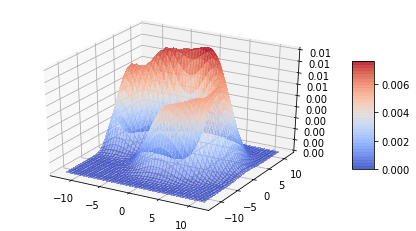

In [9]:
Xgrid = np.arange(-12, 12, 0.5)
Ygrid = np.arange(-12, 12, 0.5)
Xgrid, Ygrid = np.meshgrid(Xgrid, Ygrid)

kde1 = KDE(X1)

Xravel = list()
for i in np.arange(Xgrid.shape[0]):
    for j in np.arange(Ygrid.shape[1]):
        Xravel.append(np.array((Xgrid[i,j], Ygrid[i,j])))
Xravel = np.array(Xravel)  

Z1 = kde1.predict(Xravel)
Z1 = Z1.reshape(Xgrid.shape)

fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax.plot_surface(Xgrid, Ygrid, Z1, cmap=cm.coolwarm, alpha = 0.5,
                        linewidth=0, antialiased=False)
# Customize the z axis
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf1, shrink=0.5, aspect=5)

Classificando os pontos de acordo com o KDE:

In [34]:
kde2 = KDE(X2)

y1hat = kde1.predict(X)
y2hat = kde2.predict(X)
yhat = 1 * np.ravel(y1hat > y2hat)
confusion_matrix(y.astype(int), yhat)

array([[492,   8],
       [  7, 493]], dtype=int64)

In [36]:
acuracia = np.sum(y.astype(int) == yhat) / len(y)
acuracia

0.985

Mais uma vez, a matriz de confusão e a acurácia do classificador foram satisfatórias para o conjunto de dados sintéticos. Aqui não me preocupei em separar dados de treinamento e teste ou mesmo em fazer validação cruzada do tipo leave-one-out pois o intuito é apenas avaliar o funcionamento do algoritmo desenvolvido acima. Abaixo esses procedimentos serão devidamente realizados ao classificar a base de dados de leucemia (Golub et al). 

## Classificação da Base de Dados de Leucemia (Golub et al)

O carregamento e seleção de variáveis dessa base de dados foi explicado nos trabalhos anteriores. Desta vez, os dados serão apenas carregados sem muita explicação por economia de espaço.

In [286]:
# Carregando os dados
class_df = pd.read_csv('./data/actual.csv')
train_df = pd.read_csv('./data/data_set_ALL_AML_train.csv')
test_df = pd.read_csv('./data/data_set_ALL_AML_independent.csv')

# Tratando dados de treinamento
valid_columns = [col for col in train_df.columns if "call" not in col]
train_df = train_df[valid_columns]
train_df = train_df.T
train_df = train_df.drop(['Gene Description','Gene Accession Number'],axis=0)
train_df.index = pd.to_numeric(train_df.index)
train_df.sort_index(inplace=True)
class_dict = {'AML':0,'ALL':1}
train_df['class'] = class_df[:38]['cancer'].replace(class_dict).values

# Tratando dados de teste
valid_columns = [col for col in test_df.columns if "call" not in col]
test_df = test_df[valid_columns]
test_df = test_df.T
test_df = test_df.drop(['Gene Description','Gene Accession Number'],axis=0)
test_df.index = pd.to_numeric(test_df.index)
test_df.sort_index(inplace=True)
test_df['class'] = class_df[38:]['cancer'].replace(class_dict).values

# Selecionando os 50 genes mais relevantes
mu1 = train_df[train_df['class']==0].iloc[:,:-1].mean()
sigma1 = train_df[train_df['class']==0].iloc[:,:-1].std()
mu2 = train_df[train_df['class']==1].iloc[:,:-1].mean()
sigma2 = train_df[train_df['class']==1].iloc[:,:-1].std()
Pgc = (mu1 - mu2) / (sigma1 + sigma2)
abs_Pgc = np.abs(Pgc)
selected_genes = abs_Pgc>.91
# selected_genes = abs_Pgc>1.3
selected_genes = selected_genes.index[selected_genes.values]
print(len(selected_genes))

# Transformando para o formato de entradas e saídas X, y 
Xtrain = np.array(train_df[selected_genes])
ytrain = np.array(train_df['class'])
Xtest = np.array(test_df[selected_genes])
ytest = np.array(test_df['class'])

50


### Classificação por GMM - Bayes

Ajustando os modelos nos dados de treinamento:

In [297]:
# Classe 1
X1 = Xtrain[ytrain==0]
n_clusters = 3
GMmodel = GM(X1, n_clusters, assume_independence=True)
ll = GMmodel.fit(n_iterations = 10)

# Classe 2
X2 = Xtrain[ytrain==1]
n_clusters = 3
GMmodel2 = GM(X2, n_clusters, assume_independence=True)
ll2 = GMmodel2.fit(n_iterations = 10)

[[-3944.68567883]]
[[-3944.68567883]]
[[-3944.68567883]]
[[-3944.68567883]]
[[-3944.68567883]]
[[-3944.68567883]]
[[-3944.68567883]]
[[-3944.68567883]]
[[-3944.68567883]]
[[-3944.68567883]]


Realizando as predições para cada classe e calculando a matriz de confusão

In [306]:
yhat1 = GMmodel.predict(Xtest.astype(float))
yhat2 = GMmodel2.predict(Xtest.astype(float))
yhat = 1 * np.ravel(yhat1/yhat2 < (len(X2) / len(X1)))
confusion_matrix(ytest.astype(int), yhat)

array([[13,  1],
       [ 1, 19]], dtype=int64)

Calculando a acurácia

In [307]:
acuracia = np.sum(ytest.astype(int) == yhat)
acuracia

32

### Classificação por KDE - Bayes

In [309]:
kde1 = KDE(X1.astype(float))
kde2 = KDE(X2.astype(float))

In [313]:
y1hat = kde1.predict(Xtest.astype(float))
y2hat = kde2.predict(Xtest.astype(float))
yhat = 1 * np.ravel(y1hat < y2hat)
confusion_matrix(ytest.astype(int), yhat)

array([[13,  1],
       [ 0, 20]], dtype=int64)

In [314]:
acuracia = np.sum(y.astype(int) == yhat) / len(y)
acuracia

0.0

In [177]:
X.shape

(2000, 2)

In [16]:
np.array(data[['x1','x2']]).shape

(2000, 2)

In [23]:
k1= 10
k2 = 10
modelo = train_GM(np.array(data[['x1','x2']]), np.ravel(data[['y']].values.astype(bool)), k1, k2)

In [24]:
for i in range(k1):
    det = np.linalg.det(modelo.covL1[i])
    print(det)

7.403609155929998
0.4086869293325381
0.36707254602649964
1.1875614750020422
1.4973527602298125
0.565673290597204
0.6058823275778227
1.0522437675985044
0.9584650623383396
0.4595978267352673


In [25]:
(yhat,P1,P2) = predict_GM(np.array(data[['x1','x2']]), modelo)
accu = np.mean(yhat==np.ravel(data[['y']].values.astype(bool)))
print(accu)

0.986


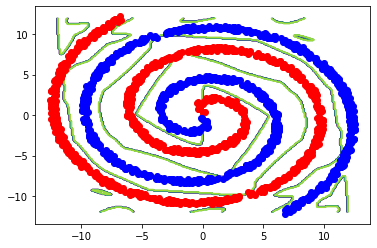

In [26]:
# Plotando superfície de separação e os dados
Np=240 #numero de pontos em uma dimensao do grid da superficie
Xgrid = np.linspace(-12,+12,Np)
(Xg,Yg) = np.meshgrid(Xgrid,Xgrid)
Z=np.zeros((Np,Np),dtype=np.float64)
for i in range(0,Np):
    for j in range(0,Np):
        xin = np.array([Xg[i,j],Yg[i,j]]).reshape((1,2))
        Z[i,j] = predict_GM(xin,modelo)[0]

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot_surface(Xg, Yg, Z)
# plt.plot(X1[:,0],X1[:,1],'or')
# plt.plot(X2[:,0],X2[:,1],'ob')
# plt.show()

fig = plt.figure()
plt.contour(Xg, Yg, Z)
plt.plot(data[data['y']==0]['x1'],data[data['y']==0]['x2'],'or')
plt.plot(data[data['y']==1]['x1'],data[data['y']==1]['x2'],'ob')
plt.show()

In [ ]:
modelo = train_GM(X,y.astype(bool),k1,k2)

for i in range(k1):
    det = np.linalg.det(modelo.covL1[i])
    print(det)

(yhat,P1,P2) = predict_GM(X, modelo)
accu = np.mean(yhat==y)
print(accu)

# Plotando superfície de separação e os dados
Np=240 #numero de pontos em uma dimensao do grid da superficie
Xgrid = np.linspace(-12,+12,Np)
(Xg,Yg) = np.meshgrid(Xgrid,Xgrid)
Z=np.zeros((Np,Np),dtype=np.float64)
for i in range(0,Np):
    for j in range(0,Np):
        xin = np.array([Xg[i,j],Yg[i,j]]).reshape((1,2))
        Z[i,j] = predict_GM(xin,modelo)[0]

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot_surface(Xg, Yg, Z)
# plt.plot(X1[:,0],X1[:,1],'or')
# plt.plot(X2[:,0],X2[:,1],'ob')
# plt.show()

fig = plt.figure()
plt.contour(Xg, Yg, Z)
plt.plot(X1[:,0],X1[:,1],'or')
plt.plot(X2[:,0],X2[:,1],'ob')
plt.show()

## Mistura de Gaussianas + Clustering

### Separando conjuntos de treinamento e teste

In [5]:
import random

n = len(data)
train_perc = 0.7
n_train = int(0.7 * n)
train_idx = random.sample(data.index.values.tolist(), n_train)
train_idx_bool = np.array([True if i in train_idx else False for i in data.index])
# Train: data[train_idx_bool], Test: data[~train_idx_bool]
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
data[train_idx_bool & (data['y']==0)].plot.scatter(x='x1', y='x2', c=data[train_idx_bool & (data['y']==0)]['y'].replace(colors), title='Conjunto de Treinamento', label='Classe 1', ax = ax1)
data[train_idx_bool & (data['y']==1)].plot.scatter(x='x1', y='x2', c=data[train_idx_bool & (data['y']==1)]['y'].replace(colors), label='Classe 2', ax = ax1)
ax2 = plt.subplot(1,2,2)
ax = data[~train_idx_bool & (data['y']==0)].plot.scatter(x='x1', y='x2', c=data[~train_idx_bool & (data['y']==0)]['y'].replace(colors), title='Conjunto de Teste', label='Classe 1', ax=ax2)
data[~train_idx_bool & (data['y']==1)].plot.scatter(x='x1', y='x2', c=data[~train_idx_bool & (data['y']==1)]['y'].replace(colors), label='Classe 2', ax = ax2)

NameError: name 'data' is not defined

## Clusterização

Rodando a clusterização nos dados de treinamento para cada uma das classes:

In [211]:
from sklearn.cluster import KMeans
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(data[train_idx_bool & (data['y']==0)][['x1','x2']])
y_kmeans = kmeans.predict(data[train_idx_bool & (data['y']==0)][['x1','x2']])
centers = kmeans.cluster_centers_

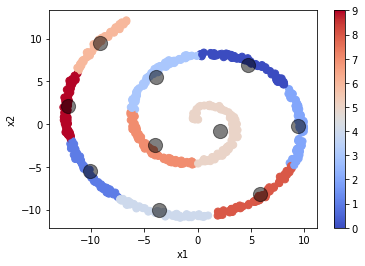

In [212]:
fig = plt.figure()
ax = fig.add_subplot(111)
data[train_idx_bool & (data['y']==0)].plot.scatter('x1', 'x2', c=y_kmeans, s=50, cmap='coolwarm', ax= ax)
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, label='dawa');

In [213]:
kmeans_df = pd.DataFrame(y_kmeans, index = data[train_idx_bool & (data['y']==0)].index)

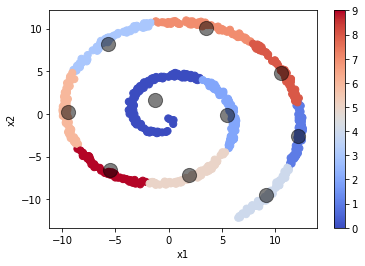

In [214]:
kmeans1 = KMeans(n_clusters=n_clusters)
kmeans1.fit(data[train_idx_bool & (data['y']==1)][['x1','x2']])
y_kmeans1 = kmeans1.predict(data[train_idx_bool & (data['y']==1)][['x1','x2']])
centers1 = kmeans1.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111)
data[train_idx_bool & (data['y']==1)].plot.scatter('x1', 'x2', c=y_kmeans1, s=50, cmap='coolwarm', ax= ax)
ax.scatter(centers1[:, 0], centers1[:, 1], c='black', s=200, alpha=0.5, label='dawa');

In [209]:
kmeans1_df = pd.DataFrame(y_kmeans1, index = data[train_idx_bool & (data['y']==1)].index)

In [210]:
kmeans_total_df = pd.concat([kmeans_df, kmeans1_df])

## KDE

In [201]:
class KDE:
    
    def __init__(self, X):
        self.X = X
        self.n, self.d = self.X.shape
        self.sd = np.std(self.X, axis=0)
        self.H = self.silvermanH()
        
    def silvermanH(self):
        """Escolha de H pela regra de Silverman de acordo com os dados de entrada."""
        H = np.power((4 / (self.d+2)), (1/(self.d+4))) * np.power(self.n, (-1/(self.d+4))) * self.sd
        H = np.power(H, 2)
        H = np.diag(H)
        return H
    
    def KH(self, x):
        """ The kernel function """
        const = np.power(2 * np.pi, -self.d/2)
        exp_term = (-1/2) * np.matmul(np.matmul(x.T, np.linalg.pinv(self.H)), x)
        Khx = const * np.power(np.linalg.det(self.H), -1/2) * np.exp(exp_term)
        return np.ravel(Khx)
    
    
    def predict(self, Xnew):
        assert (Xnew.shape[1] == self.d)
        Yhat = np.zeros((Xnew.shape[0], 1))
        for i, xn in enumerate(Xnew):
            xn = xn.reshape(self.d, 1)
            KHi = 0
            for j, x in enumerate(self.X):
                x = x.reshape((self.d,1))
                KHi += self.KH(xn-xi)
            Yhat[i] = KHi/self.n
        return Yhat
    
    def predict(self, Xnew):
        assert (Xnew.shape[1] == self.d)
        Yhat = np.zeros((Xnew.shape[0], 1))
        for i, xn in enumerate(Xnew):
            xn = xn.reshape(self.d, 1)
            KHi = 0
            for j, x in enumerate(self.X):
                x = x.reshape((self.d,1))
                KHi += self.KH(xn-x)
            Yhat[i] = KHi/self.n
        return Yhat

Calculando e plotando o Kernel da classe 1:

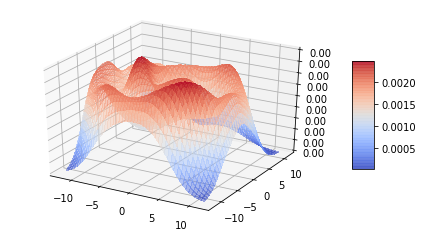

In [204]:
Xgrid = np.arange(-12, 12, 0.5)
Ygrid = np.arange(-12, 12, 0.5)
Xgrid, Ygrid = np.meshgrid(Xgrid, Ygrid)

X1 = np.array(data[data['y']==0][['x1', 'x2']])
kde1 = KDE(X1)

Xravel = list()
for i in np.arange(Xgrid.shape[0]):
    for j in np.arange(Ygrid.shape[1]):
        Xravel.append(np.array((Xgrid[i,j], Ygrid[i,j])))
Xravel = np.array(Xravel)  

Z1 = kde1.predict(Xravel)
Z1 = Z1.reshape(Xgrid.shape)

fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax.plot_surface(Xgrid, Ygrid, Z1, cmap=cm.coolwarm, alpha = 0.5,
                        linewidth=0, antialiased=False)
# Customize the z axis
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf1, shrink=0.5, aspect=5)

## Classificando os dados da espiral

In [ ]:
X1 = np.array(data[data['y']==0][['x1', 'x2']])
kde1 = KDE(X1)
X2 = np.array(data[data['y']==1][['x1', 'x2']])
kde2 = KDE(X2)

In [199]:
Xgrid = np.arange(-12, 12, 2)
Ygrid = np.arange(-12, 12, 2)
Xgrid, Ygrid = np.meshgrid(Xgrid, Ygrid)

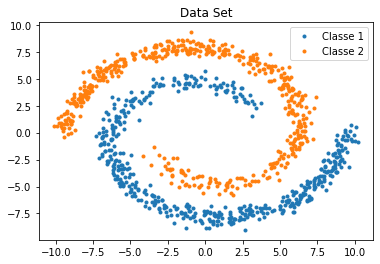

In [210]:
import numpy as np
from matplotlib import pyplot as plt


# Função para geração da base de dados sintética
def twospirals(n_points, n_turns, ts=np.pi, tinc=1, noise=.3):
    """
     Returns the two spirals dataset.
     modificado de: 
         https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
    Primeiro gera uma espiral e obtem a segunda espelhando a primeira
    """
    # equação da espiral (coord polares): r = tinc*theta
    # n_points: número de pontos de cada espiral
    # n_turns: número de voltas das espirais
    # ts: ângulo inicial da espiral em radianos
    # tinc: taxa de crescimento do raio em função do ângulo
    # noise: desvio-padrão do ruído
    
    # Sorteando aleatoriamente pontos da espiral
    n = np.sqrt(np.random.rand(n_points,1))  #intervalo [0,1] equivale a [0,theta_max]
                                             #tomar a raiz quadrada ajuda a 
                                             #distribuir melhor os pontos
    ns = (ts)/(2*np.pi*n_turns) #ponto do intervalo equivalente a ts radianos
    n = ns + n_turns*n # intervalo [ns,ns+n_turns] equivalente a [ts, theta_max]
    n = n*(2*np.pi) #intervalo [ts, theta_max]
    
    # Espiral 1
    d1x = np.cos(n)*tinc*n + np.random.randn(n_points,1) * noise
    d1y = np.sin(n)*tinc*n + np.random.randn(n_points,1) * noise
    
    # Espiral 2
    d2x = -np.cos(n)*tinc*n + np.random.randn(n_points,1) * noise
    d2y = -np.sin(n)*tinc*n + np.random.randn(n_points,1) * noise
    
    spirals_points = np.vstack((np.hstack((d1x,d1y)),np.hstack((d2x,d2y))))
    points_labels = np.hstack((np.ones(n_points),np.zeros(n_points)))
    return (spirals_points, points_labels)

Xspiral, yspiral = twospirals(500,1,ts=np.pi,tinc=1,noise=0.4)
plt.figure()
plt.title('Data Set')
plt.plot(Xspiral[yspiral==0,0], Xspiral[yspiral==0,1], '.', label='Classe 1')
plt.plot(Xspiral[yspiral==1,0], Xspiral[yspiral==1,1], '.', label='Classe 2')
plt.legend()
plt.show()

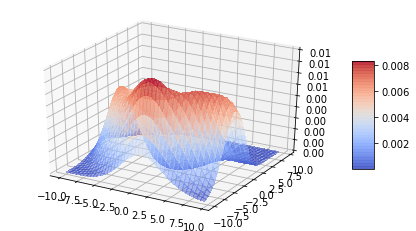

In [213]:
Xgrid = np.arange(-10, 10, 0.5)
Ygrid = np.arange(-10, 10, 0.5)
Xgrid, Ygrid = np.meshgrid(Xgrid, Ygrid)

X1 = Xspiral[yspiral==0]
kde1 = KDE(X1)

Xravel = list()
for i in np.arange(Xgrid.shape[0]):
    for j in np.arange(Ygrid.shape[1]):
        Xravel.append(np.array((Xgrid[i,j], Ygrid[i,j])))
Xravel = np.array(Xravel)  

Z1 = kde1.predict(Xravel)
Z1 = Z1.reshape(Xgrid.shape)

fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax.plot_surface(Xgrid, Ygrid, Z1, cmap=cm.coolwarm, alpha = 0.5,
                        linewidth=0, antialiased=False)
# Customize the z axis
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf1, shrink=0.5, aspect=5)

C:\Users\ramon\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: No contour levels were found within the data range.
  after removing the cwd from sys.path.


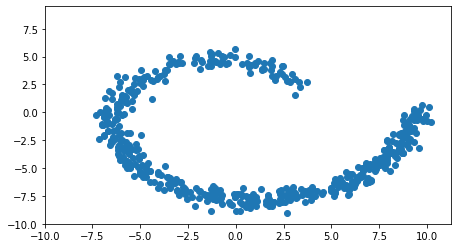

In [214]:
fig = plt.figure(figsize=plt.figaspect(0.25))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X1[:,0], X1[:,1])
ax1.contour(Xgrid,Ygrid,Z1, [1.], colors='k')

In [202]:
X1 = np.array(data[data['y']==0][['x1', 'x2']])
kde1 = KDE(X1)
X2 = np.array(data[data['y']==1][['x1', 'x2']])
kde2 = KDE(X2)
Xravel = list()
for i in np.arange(Xgrid.shape[0]):
    for j in np.arange(Ygrid.shape[1]):
        Xravel.append(np.array((Xgrid[i,j], Ygrid[i,j])))
Xravel = np.array(Xravel)  

Z1 = kde1.predict(Xravel)
Z1 = Z1.reshape(Xgrid.shape)
Z2 = kde2.predict(Xravel)
Z2 = Z2.reshape(Xgrid.shape)

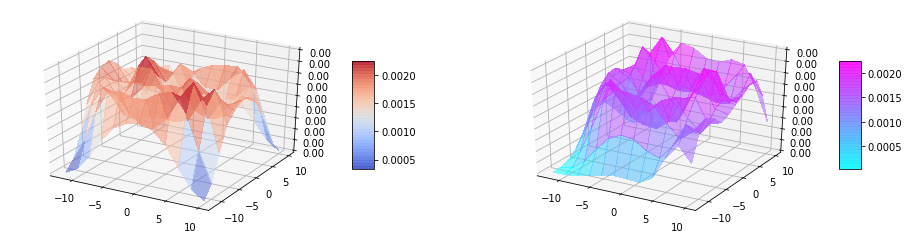

In [203]:
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax.plot_surface(Xgrid, Ygrid, Z1, cmap=cm.coolwarm, alpha = 0.5,
                        linewidth=0, antialiased=False)

#surf2 = ax.plot_surface(X, Y, Z2, cmap=cm.cool, alpha = 0.5,
#                        linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-.35)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf1, shrink=0.5, aspect=5)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(Xgrid, Ygrid, Z2, cmap=cm.cool, alpha = 0.5,
                        linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-.35)
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf2, shrink=0.5, aspect=5)

In [130]:
np.array((Xgrid[0,0], Xgrid[0,0]))

array([3., 3.])

In [69]:
def silvermanH(X):
    """Escolha de H pela regra de Silverman de acordo com os dados de entrada."""
    
    n, d = X.shape
    sd = np.std(X, axis=0)
    
    H = np.power((4 / (d+2)), (1/(d+4))) * np.power(n, (-1/(d+4))) * sd
    H = np.power(H, 2)
    H = np.diag(H)
    return H


def Kh(x, H):
    d = x.shape[0]
    const = np.power(2 * np.pi, -d/2)
    exp_term = (-1/2) * np.matmul(np.matmul(x.T, np.linalg.pinv(H)), x)
    Khx = const * np.power(np.linalg.det(H), -1/2) * np.exp(exp_term)
    return np.ravel(Khx)

In [66]:
X = np.array(data1[['x1','x2']])
sH = silvermanH(X)
sH

array([[0.08536469, 0.        ],
       [0.        , 0.09223651]])

In [67]:
xi = X[0,:].reshape(2,1)
xi.shape

(2, 1)

In [73]:
kh = Kh(xi, sH)

In [77]:
np.ravel(kh).shape


(1,)

In [39]:
?np.power

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 19 20:30:42 2020

@author: Henrico
"""

#Funcoes de classificacao e treinamento

import numpy as np
from sklearn.cluster import KMeans
"""-------------------------------------------------------------------------"""
""" Gaussiana Multivariável"""
def myMultiGauss(xv, muv, covm):
    # Implementa função gaussiana multivariável
    # https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    # Entradas
    #   xv: vetor de entrada, matriz nx1
    #   muv: vetor de médias, matriz nx1
    #   covm: matriz de covariância nxn
    # Saídas
    
    n = xv.size #dimensão da entrada
    nf = ( ((2*np.pi)**n)*np.linalg.det(covm) )**0.5 #fator de normalização
    xv=xv-muv
    covinv=np.linalg.pinv(covm)
    mat = np.matmul(xv.T,covinv)
    mat = np.matmul(mat,xv)
    fx = np.exp( -0.5*(mat))/nf
    fx=np.float64(fx)
    
    return fx
"""------------------------------------------------------------------------"""

""" Correlação do Golub"""
#-----------------------------------------------------------------------------     
def calcPgc(g,c):
    #Função para calcular P(g,c), medida de correlação propostas no artigo 
    # original
    # Entradas:
    # g: (float) matriz Ng x Ni com a expressão gênica para cada indivíduo.
    #    Ng é o número de genes, Ni é o número de indivíduos
    # c: (bool) vetor booleano Ngx1 com a "expressão idealizada". '1'indica classe 1 e 
    #    '0' indica classe 2
    # 
    # Saídas:
    # pgc: vetor Ngx1 com o grau de correlação de cada gene
    
    mu1g = np.mean(g[:,c],axis=1)
    sd1g = np.std(g[:,c],axis=1,ddof=1)
    mu2g = np.mean(g[:,np.logical_not(c)],axis=1) 
    sd2g = np.std(g[:,np.logical_not(c)],axis=1,ddof=1)
    
    pgc = (mu1g-mu2g)/(sd1g+sd2g)
    
    return pgc
"""------------------------------------------------------------------------"""

""" Bayes com duas Gaussianas """
#-----------------------------------------------------------------------------
class model_2G:
    def __init__(self,mu1,mu2,std1,std2,k):
        # n = dimensão (nº de caracteristicas) dos dados
        self.mu1 = mu1 #vetor nx1 com as médias de cada variável para classe 1
        self.mu2 = mu2 #vetor nx1 com as médias de cada variável para classe 2
        self.std1 = std1 #matrix nx1 com os desvios-padrões para classe 1
        self.std2 = std2 #matrix nx1 com os desvios-padrões para classe 2
        self.k = k #proporção N2/N1 = P(C2)/P(C1)
    def show(self):
        print('mu1 = ', self.mu1,', std1 = ',self.std1)
        print('mu2 = ', self.mu2,', std2 = ',self.std2)
        print('k = ', self.k)

def train_2G(data,labels):
    # data: matriz Nxn com a N amostras de n dimensões
    # labels: vetor Nx1 com os rótulos de cada classe.  True - classe 1
    #                                                   False - classe 2
    N=labels.size
    N1=np.sum(labels)
    N2=N-N1
    k = N2/N1
    
    data1=data[labels,:]
    data2=data[np.logical_not(labels),:]        
    mu1 = np.mean(data1,axis=0)
    mu2 = np.mean(data2,axis=0)
    std1 = np.std(data1,axis=0,ddof=1)
    std2 = np.std(data2,axis=0,ddof=1)
    
    modelo = model_2G(mu1,mu2,std1,std2,k)
    return modelo
       
def predict_2G(xin,model):
    
    if (xin.shape==(xin.size,)): #Caso entrada única
        xin=xin.reshape((1,xin.size))
        
    N=xin.shape[0]
    label=-1*np.ones(N)
    for i in range(0,N):            
        P_xc1=myMultiGauss(xin[i,:], model.mu1, np.diag(model.std1))
        P_xc2=myMultiGauss(xin[i,:], model.mu2, np.diag(model.std2))
        label[i] = (P_xc1/P_xc2) > model.k
    
    return label
"""------------------------------------------------------------------------"""


""" Mistura de Gaussianas """
"""------------------------------------------------------------------------"""
class model_GM:
    def __init__(self,muL1,muL2,covL1,covL2,kL1,kL2,k):
        # n = dimensão (nº de caracteristicas) dos dados
        # Nk1 = número de amostras da partição k que pertence a classe 1
        # Nk2 = número de amostras da partição k que pertence a classe 2
        # N = número total de amostras
        self.muL1 = muL1 #Lista  as médias de cada partição para cada gaussiana associada a classe 1
        self.muL2 = muL2 #idem a muL1 para a classe2
        self.covL1 = covL1 #lista com as matrizes de covariância de cada gaussiana da classe 1
        self.covL2 = covL2 #idem a covl1 para a classe 2
        self.kL1 = kL1 #array de proporções das partições da classe 1 Nk1/N1
        self.kL2 = kL2 #array de proporções das partições da classe 1 Nk2/N2
        self.k = k #Proporção entre as classes P(C2)/P(C1) = N2/N1
#-----------------------------------------------------------------------------

def train_GM(data,labels,k1,k2):
    # data: matriz Nxn com a N amostras de n dimensões, n>1
    # labels: vetor Nx1 com os rótulos de cada classe.  True - classe 1
    #                                                   False - classe 2
    # k1, k2: Número de partições a se usar para a classe 1 e para a class2
    #         Obs: particionamento feito usando K-médias
    
    N=labels.size
    N1=np.sum(labels)
    N2=N-N1
    k  = N2/N1
    
    data1=data[labels,:]
    data2=data[np.logical_not(labels),:]    
    
    # Particiona a classe 1
    kM1 = KMeans(n_clusters=k1, init='k-means++', max_iter=300, 
                 n_init=10, random_state=0)
    kM1.fit(data1)
    # Extrai dados de média e desvio-padrão para a classe 1
    muL1=list()
    covL1=list()
    kL1 = np.zeros(k1,dtype=float)
    for i in range(k1):
        li = kM1.labels_ == i #posições das amostras da partição i
        ki_data = data1[li,:] #amostras pertencentes a partição i
        muL1.append(np.mean(ki_data,axis=0))
        covL1.append(np.cov(ki_data.T)) #matriz de covariância da partição
        kL1[i]=np.sum(li)/N1 #proporção da partição
    
    
    # Particiona a classe 2
    kM2 = KMeans(n_clusters=k2, init='k-means++', max_iter=300, 
                 n_init=10, random_state=0)
    kM2.fit(data2)
    # Extrai dados de média e desvio-padrão para a classe 2
    muL2=list()
    covL2=list()
    kL2 = np.zeros(k2,dtype=float)
    for i in range(k2):
        li = kM2.labels_ == i #posições dos elementos da partição i
        ki_data = data2[li,:] #pontos pertencentes a partição i
        muL2.append(np.mean(ki_data,axis=0))
        covL2.append(np.cov(ki_data.T)) #matriz de covariância da partição
        kL2[i]=np.sum(li)/N2 #proporção da partição
    
    modelo = model_GM(muL1,muL2,covL1,covL2,kL1,kL2,k)
    return modelo

#-----------------------------------------------------------------------------
def predict_GM(data,modelo):
    # Classifica as novas amostras
    Nk1 = len(modelo.muL1) #Número de partições da classe 1
    Nk2 = len(modelo.muL2) #Número de partições da classe 2
    
    N = data.shape[0] #número de amostras a classificar
    P1 = np.zeros(N)
    P2 = np.zeros(N)
    label = np.zeros(N,dtype=bool)
    for i in range(N):
        x = data[i,:]
        # Calcula P(x|C1)
        PxC1 = 0
        for k in range(Nk1):
            muv = modelo.muL1[k]
            covm = modelo.covL1[k]
            pik = modelo.kL1[k]
            PxC1 = PxC1 + pik*myMultiGauss(x, muv, covm)
        P1[i]=PxC1
        
        # Calcula P(x|C2)
        PxC2 = 0
        for k in range(Nk2):
            muv = modelo.muL2[k]
            covm = modelo.covL2[k]
            pik = modelo.kL2[k]
            PxC2 = PxC2 + pik*myMultiGauss(x, muv, covm)
        P2[i]=PxC2
        # Classifica
        label[i] = (PxC1/PxC2) > modelo.k
    
    return label, P1, P2

'------------------------------------------------------------------------'

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 19 23:12:57 2020

@author: Henrico
"""

import numpy as np
from matplotlib import pyplot as plt


# Função para geração da base de dados sintética
def twospirals(n_points, n_turns, ts=np.pi, tinc=1, noise=.3):
    """
     Returns the two spirals dataset.
     modificado de: 
         https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
    Primeiro gera uma espiral e obtem a segunda espelhando a primeira
    """
    # equação da espiral (coord polares): r = tinc*theta
    # n_points: número de pontos de cada espiral
    # n_turns: número de voltas das espirais
    # ts: ângulo inicial da espiral em radianos
    # tinc: taxa de crescimento do raio em função do ângulo
    # noise: desvio-padrão do ruído
    
    # Sorteando aleatoriamente pontos da espiral
    n = np.sqrt(np.random.rand(n_points,1))  #intervalo [0,1] equivale a [0,theta_max]
                                             #tomar a raiz quadrada ajuda a 
                                             #distribuir melhor os pontos
    ns = (ts)/(2*np.pi*n_turns) #ponto do intervalo equivalente a ts radianos
    n = ns + n_turns*n # intervalo [ns,ns+n_turns] equivalente a [ts, theta_max]
    n = n*(2*np.pi) #intervalo [ts, theta_max]
    
    # Espiral 1
    d1x = np.cos(n)*tinc*n + np.random.randn(n_points,1) * noise
    d1y = np.sin(n)*tinc*n + np.random.randn(n_points,1) * noise
    
    # Espiral 2
    d2x = -np.cos(n)*tinc*n + np.random.randn(n_points,1) * noise
    d2y = -np.sin(n)*tinc*n + np.random.randn(n_points,1) * noise
    
    spirals_points = np.vstack((np.hstack((d1x,d1y)),np.hstack((d2x,d2y))))
    points_labels = np.hstack((np.ones(n_points),np.zeros(n_points)))
    return (spirals_points, points_labels)

def twospirals_example():
    X, y = twospirals(500,1,ts=np.pi,tinc=1,noise=0.4)
    plt.figure()
    plt.title('Data Set')
    plt.plot(X[y==0,0], X[y==0,1], '.', label='Classe 1')
    plt.plot(X[y==1,0], X[y==1,1], '.', label='Classe 2')
    plt.legend()
    plt.show()

# -----------------------------------------------------------------------------
    
X, y = twospirals(500,1,ts=np.pi,tinc=1,noise=0.4)
X1 = X[y==1,:]
X2 = X[y==0,:]
k1=10
k2=10
N1 = 500
N2 = 500

In [3]:
modelo = train_GM(X,y.astype(bool),k1,k2)

for i in range(k1):
    det = np.linalg.det(modelo.covL1[i])
    print(det)

(yhat,P1,P2) = predict_GM(X, modelo)
accu = np.mean(yhat==y)
print(accu)

# Plotando superfície de separação e os dados
Np=240 #numero de pontos em uma dimensao do grid da superficie
Xgrid = np.linspace(-12,+12,Np)
(Xg,Yg) = np.meshgrid(Xgrid,Xgrid)
Z=np.zeros((Np,Np),dtype=np.float64)
for i in range(0,Np):
    for j in range(0,Np):
        xin = np.array([Xg[i,j],Yg[i,j]]).reshape((1,2))
        Z[i,j] = predict_GM(xin,modelo)[0]

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot_surface(Xg, Yg, Z)
# plt.plot(X1[:,0],X1[:,1],'or')
# plt.plot(X2[:,0],X2[:,1],'ob')
# plt.show()

fig = plt.figure()
plt.contour(Xg, Yg, Z)
plt.plot(X1[:,0],X1[:,1],'or')
plt.plot(X2[:,0],X2[:,1],'ob')
plt.show()

0.2149167838185004
0.1179868282584365
0.20668933831452743
0.13865635098457157
0.3030334890345211
0.14498259440344968
0.12310911412316909
0.15058900051997373
0.3131282157530327
0.11929147902844689
1.0


<Figure size 640x480 with 1 Axes>

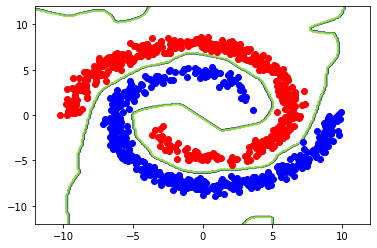

In [4]:
plt.contour(Xg, Yg, Z)
plt.plot(X1[:,0],X1[:,1],'or')
plt.plot(X2[:,0],X2[:,1],'ob')
plt.show()

## Classificador Bayesiano

Assume normalidade para as classes

### Média e Covariância Amostral por classe:

In [2]:
def estimate_means_and_covariances(data):
    classes = data.y.unique()
    result = {'covariances': list(),
             'means': list()}
    for c in classes:
        d = data[data['y']==c].loc[:,data.columns != 'y']
        cov = np.cov(d.T)
        mean = np.mean(d).values
        result['covariances'].append(cov)
        result['means'].append(mean)
    return result

In [3]:
stats = estimate_means_and_covariances(data)
stats

{'covariances': [array([[ 0.59159635, -0.05219555],
         [-0.05219555,  0.41875764]]), array([[ 0.72562221, -0.59224901],
         [-0.59224901,  0.66566701]])],
 'means': [array([5.0275359 , 5.00023153]), array([6.52075218, 6.47378106])]}

Nota-se que a covariância amostral (estimada acima) é próxima à covariância utilizada para gerar os dados.

### Função de Densidade de Probabilidade Multivariada

Regra de Bayes:

$P(C_i|x) = \frac{P(x|C_i)*P(C_i)}{P(x)}$

Em que $P(C_i)$ é uma contagem, $P(x)$ é um normalizador (não necessário aqui) e $P(x|C_i)$ é o "core" do classificador em si. 

Implementando a função de densidade de probabilidade multivariada:

$f(x;\mu,\Sigma)=\frac{1}{\sqrt{(2\pi)^k*det(\Sigma)}}*e^{-\frac{1}{2}*((x-\mu)^T \cdot inv(\Sigma) \cdot (x-\mu))}$

In [4]:
def multivariate_pdf(x, mean, cov):
    size = len(x)
    x = np.array(x).reshape((1, size))
    mean = np.array(mean).reshape((1, size))
    cov = np.array(cov).reshape((size,size))
    if x.shape == mean.shape and (size, size) == cov.shape:
        det = np.linalg.det(cov)
        term1 = 1.0 / ( np.power((2*np.pi),(float(size)/2)) * np.power(det, 0.5))
        term2 = x-mean
        term3 = np.linalg.pinv(cov)
        term4 = np.power(np.e,(-0.5 * np.matmul(np.matmul(term2,  term3), term2.T)))
        return term1 * term4

Avaliando a função no primeiro ponto, utilizando as médias e matrizes de covariância relativas a cada uma das classes, espera-se que o valor retornado pela classe 1 seja maior que o valor retornado pela classe 2:

In [5]:
multivariate_pdf(data.loc[:,data.columns!='y'].iloc[0], 
                 stats['means'][0],  # mu1 
                 stats['covariances'][0]) # Sigma1

array([[0.06634934]])

In [6]:
multivariate_pdf(data.loc[:,data.columns!='y'].iloc[0], 
                 stats['means'][1], # mu2
                 stats['covariances'][1]) # Sigma 2

array([[1.06822561e-12]])

De fato este é o caso!

### Visualização da Fronteira de Decisão e das Superfícies de Probabilidade

Calculando as superfícies de densidade de probabilidade para cada classe:

In [7]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

X = np.arange(3, 9.25, 0.25)
Y = np.arange(3, 9.25, 0.25)
X, Y = np.meshgrid(X, Y)

Z1 = np.zeros(X.shape)
Z2 = np.zeros(X.shape)

for i in np.arange(X.shape[0]):
    for j in np.arange(X.shape[1]):
        Z1[i, j] = multivariate_pdf([X[i,j], Y[i,j]], 
                     stats['means'][0],  # mu1 
                     stats['covariances'][0]) # Sigma1
        Z2[i, j] = multivariate_pdf([X[i,j], Y[i,j]], 
                     stats['means'][1],  # mu1 
                     stats['covariances'][1]) # Sigma1

Abaixo, a superfície exibida à esquerda é a PDF resultante da subtração da PDF da classe 1 pela da classe 2. Isso é feito apenas para melhorar a visualização, já que não fariam sentido probabilidades negativas. À direita podemos ver a curva de separação resultante em duas dimensões $\frac{P(x|C_1)}{P(x|C_2)} = 1$.

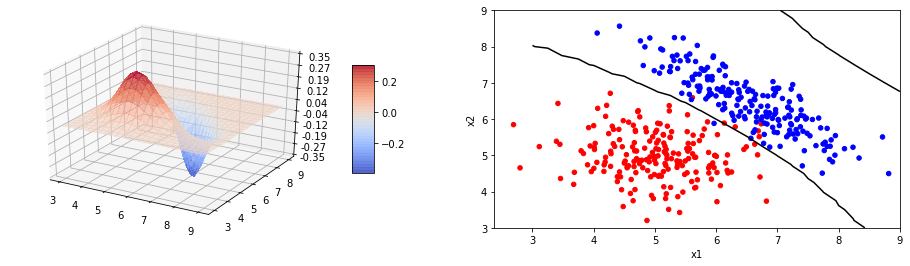

In [8]:
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax.plot_surface(X, Y, Z1-Z2, cmap=cm.coolwarm, alpha = 0.5,
                        linewidth=0, antialiased=False)

#surf2 = ax.plot_surface(X, Y, Z2, cmap=cm.cool, alpha = 0.5,
#                        linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-.35, .35)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf1, shrink=0.5, aspect=5)


ax1 = fig.add_subplot(1, 2, 2)
data.plot.scatter(x='x1', y='x2', c=data['y'].replace(colors), ax=(ax1))
ax1.contour(X,Y,(Z1/Z2), [1.], colors='k')

## Repetindo o processo para um segundo conjunto de dados sintético:

Para explorar as propriedades do classificador, todo o processo acima será repetido para novos dados sintéticos. Dessa vez, haverá desbalanceamento entre as classes e uma delas estará mais concentrada em uma região.

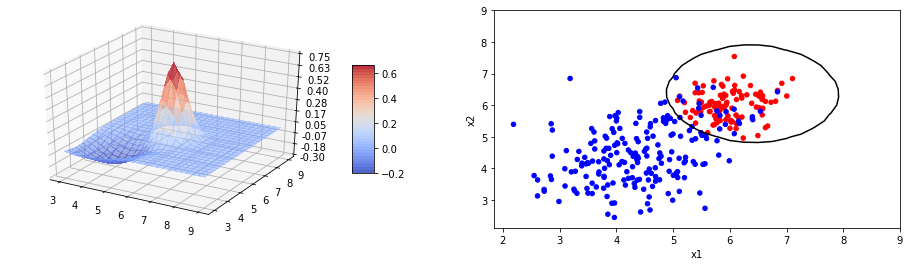

In [9]:
# Gerando os dados
mean1 = np.array((6,6))
cov1 = np.array(((.2, 0.),
                 (0., .2)))
n1 = 100
y1 = 0
data1 = pd.DataFrame(np.random.multivariate_normal(mean1, cov1, n1), columns=['x1','x2'])
data1['y'] = y1

mean2 = np.array((4.5,4.5))
cov2 = np.array(((.8, 0.3),
                 (0.3, .8)))
n2 = 200
y2 = 1
data2 = pd.DataFrame(np.random.multivariate_normal(mean2, cov2, n2), columns=['x1','x2'])
data2['y'] = y2

colors = {0: 'red', 1: 'blue'}
data = pd.concat([data1, data2])

stats = estimate_means_and_covariances(data)
stats

X = np.arange(3, 9.25, 0.25)
Y = np.arange(3, 9.25, 0.25)
X, Y = np.meshgrid(X, Y)

Z1 = np.zeros(X.shape)
Z2 = np.zeros(X.shape)

for i in np.arange(X.shape[0]):
    for j in np.arange(X.shape[1]):
        Z1[i, j] = multivariate_pdf([X[i,j], Y[i,j]], 
                     stats['means'][0],  # mu1 
                     stats['covariances'][0]) # Sigma1
        Z2[i, j] = multivariate_pdf([X[i,j], Y[i,j]], 
                     stats['means'][1],  # mu1 
                     stats['covariances'][1]) # Sigma1
        
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax.plot_surface(X, Y, Z1-Z2, cmap=cm.coolwarm, alpha = 0.5,
                        linewidth=0, antialiased=False)

#surf2 = ax.plot_surface(X, Y, Z2, cmap=cm.cool, alpha = 0.5,
#                        linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-.3, .75)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf1, shrink=0.5, aspect=5)


ax1 = fig.add_subplot(1, 2, 2)
data.plot.scatter(x='x1', y='x2', c=data['y'].replace(colors), ax=(ax1))
ax1.contour(X,Y,(Z1/Z2), [1.], colors='k')

# Classificando os dados de Leucemia (Golub et al)

## Pré-processamento de dados 

Bem como no trabalho anterior, os dados serão limpados e o conjunto de genes mais relevante para a classificação será selecionado antes da classificação em si. As explicações detalhadas de cada processo estão no relatório anterior, de replicação do trabalho de Golub et al. Aqui elas foram removidas por economia de espaço.

### Carregando e Limpeza os Dados

Dados de treinamento

In [10]:
class_df = pd.read_csv('./data/actual.csv')
train_df = pd.read_csv('./data/data_set_ALL_AML_train.csv')
test_df = pd.read_csv('./data/data_set_ALL_AML_independent.csv')

valid_columns = [col for col in train_df.columns if "call" not in col]
train_df = train_df[valid_columns]
train_df = train_df.T
train_df = train_df.drop(['Gene Description','Gene Accession Number'],axis=0)
train_df.index = pd.to_numeric(train_df.index)
train_df.sort_index(inplace=True)
class_dict = {'AML':0,'ALL':1}
train_df['class'] = class_df[:38]['cancer'].replace(class_dict).values
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,class
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,1
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,1
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,1
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,1
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,1


Dados de teste:

In [11]:
valid_columns = [col for col in test_df.columns if "call" not in col]
test_df = test_df[valid_columns]
test_df = test_df.T
test_df = test_df.drop(['Gene Description','Gene Accession Number'],axis=0)
test_df.index = pd.to_numeric(test_df.index)
test_df.sort_index(inplace=True)
test_df['class'] = class_df[38:]['cancer'].replace(class_dict).values
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,class
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,1023,67,214,-135,1074,475,48,168,-70,1
40,-87,-248,262,295,-226,-493,367,-452,194,162,...,529,-295,352,-67,67,263,-33,-33,-21,1
41,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,383,46,104,15,245,164,84,100,-18,1
42,22,-153,17,276,-211,-250,55,-141,0,500,...,399,16,558,24,893,297,6,1971,-42,1
43,86,-36,-141,252,-201,-384,-420,-197,-60,-468,...,91,-84,615,-52,1235,9,7,1545,-81,1


### Seleção de Genes Relevantes

In [12]:
mu1 = train_df[train_df['class']==0].iloc[:,:-1].mean()
sigma1 = train_df[train_df['class']==0].iloc[:,:-1].std()
mu2 = train_df[train_df['class']==1].iloc[:,:-1].mean()
sigma2 = train_df[train_df['class']==1].iloc[:,:-1].std()
Pgc = (mu1 - mu2) / (sigma1 + sigma2)
abs_Pgc = np.abs(Pgc)

selected_genes = abs_Pgc>.91
selected_genes = selected_genes.index[selected_genes.values]
train_df[selected_genes].shape

(38, 50)

Nota-se que agora o conjunto de dados tem 38 observações mas apenas 50 genes.

## Classificação por Bayes

### Estimando as Médias e Matrizes de Covariância

In [99]:
from sklearn.preprocessing import StandardScaler

training_data = train_df[selected_genes]
training_data = training_data.astype(float)
training_data['y'] = train_df['class']

stats = estimate_means_and_covariances(training_data)

### Classificação

Para classificar os dados sem erros numéricos, utilizou-se o tipo de dados "Decimal" do Python, devido à sua precisão aumentada. Além disso, assumiu-se independência na distribuição.

In [96]:
from decimal import Decimal

testing_data = test_df[selected_genes]
testing_data = testing_data.astype(float)
testing_data['y'] = test_df['class']

n_test = testing_data.shape[0]
PxC1 = np.zeros((n_test, 1))
PxC2 = np.zeros((n_test, 1))

for i in np.arange(n_test):
    x = testing_data.loc[:,testing_data.columns != 'y'].iloc[i,:].values
    PxC1[i] = multivariate_pdf(x,
                               stats['means'][0],  # mu1 
                               stats['covariances'][0]) # Sigma1
    PxC2[i] = multivariate_pdf(x.astype(Decimal),
                                stats['means'][1],  # mu1 
                                np.diag(np.diag(stats['covariances'][1]))) # Sigma1
predicted_classes = np.ravel(1*np.array(PxC1 > PxC2)) 
predicted_classes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

Calculando a matriz de confusão para avaliar os resultados da classificação:

In [97]:
confusion_matrix(testing_data.y, predicted_classes)

array([[12,  2],
       [ 0, 20]], dtype=int64)

Nota-se que, das 34 observações do conjunto de teste, 32 foram classificadas corretamente!

A performance do classificador foi satisfatória e semelhante à obtida no exercício anterior (replicando os resultados de Golub et al).